## Problem Statement

Accurate sales forecasting is critical for inventory planning, revenue forecasting, and strategic decision-making.  
The objective of this analysis is to forecast **monthly sales** using historical Superstore transaction data and to compare multiple time-series and machine learning approaches to identify the most effective model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet


In [2]:
sales_df=pd.read_csv("Kaggle Superstore Sales Forecasting.csv")
print(sales_df.info())
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


### Data Quality Notes

The dataset contains 9,800 records across 18 columns, most of which are categorical (object-type) features representing identifiers or labels. As a result, outlier detection is not applicable to these columns. The primary numerical variable, Sales, will be analyzed after monthly aggregation, which naturally smooths extreme transactional values.

The Row ID column is a sequential identifier with no analytical value and can be safely removed. Additionally, the Postal Code column contains a small number of missing values; given their limited impact on the analysis, these rows or the column itself can be dropped without affecting results.


In [3]:
# Drop non-informative identifier column
sales_df = sales_df.drop(columns=["Row ID"])

# Handle missing values in Postal Code
# Since the number of nulls is very small, drop affected rows
sales_df = sales_df.dropna(subset=["Postal Code"])

# Convert date columns to datetime
sales_df["Order Date"] = pd.to_datetime(sales_df["Order Date"],format="%d/%m/%Y")
sales_df["Ship Date"] = pd.to_datetime(sales_df["Ship Date"],format="%d/%m/%Y")

sales_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9789 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9789 non-null   object        
 1   Order Date     9789 non-null   datetime64[ns]
 2   Ship Date      9789 non-null   datetime64[ns]
 3   Ship Mode      9789 non-null   object        
 4   Customer ID    9789 non-null   object        
 5   Customer Name  9789 non-null   object        
 6   Segment        9789 non-null   object        
 7   Country        9789 non-null   object        
 8   City           9789 non-null   object        
 9   State          9789 non-null   object        
 10  Postal Code    9789 non-null   float64       
 11  Region         9789 non-null   object        
 12  Product ID     9789 non-null   object        
 13  Category       9789 non-null   object        
 14  Sub-Category   9789 non-null   object        
 15  Product Name   9789 non-nu

### Monthly Aggregation Rationale

The original data is at a transactional (order-level) granularity, which can introduce high day-to-day volatility due to promotions, bulk orders, or irregular customer behavior. Aggregating sales at a **monthly level** smooths these short-term fluctuations, reduces the impact of extreme daily values, and makes underlying **trend and seasonality** patterns easier to model. This aggregation level is also more aligned with typical business planning and forecasting use cases.


In [4]:
# Aggregate to monthly total sales
monthly = (
    sales_df
    .groupby(pd.Grouper(key="Order Date", freq="ME"))["Sales"]
    .sum()
    .reset_index()
)

monthly.columns = ["date", "sales"]
monthly = monthly.sort_values("date")

print(monthly.head())
print("Monthly rows:", monthly.shape)
print("Date range:", monthly["date"].min(), "to", monthly["date"].max())


        date      sales
0 2015-01-31  14205.707
1 2015-02-28   4519.892
2 2015-03-31  55205.797
3 2015-04-30  27906.855
4 2015-05-31  23644.303
Monthly rows: (48, 2)
Date range: 2015-01-31 00:00:00 to 2018-12-31 00:00:00


In [5]:
# 80/20 chronological split
split_idx = int(len(monthly) * 0.8)

train = monthly.iloc[:split_idx].copy()
test  = monthly.iloc[split_idx:].copy()

print("Train months:", len(train))
print("Test months:", len(test))
print("Train period:", train["date"].min(), "to", train["date"].max())
print("Test period:", test["date"].min(), "to", test["date"].max())


Train months: 38
Test months: 10
Train period: 2015-01-31 00:00:00 to 2018-02-28 00:00:00
Test period: 2018-03-31 00:00:00 to 2018-12-31 00:00:00


In [6]:
test["baseline_pred"] = train["sales"].iloc[-1]

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mse_baseline = mean_squared_error(
    test["sales"], test["baseline_pred"]
)

rmse_baseline = np.sqrt(mse_baseline)
mape_baseline = mape(test["sales"], test["baseline_pred"])

print(f"Baseline RMSE: {rmse_baseline:.2f}")
print(f"Baseline MAPE: {mape_baseline:.2f}%")

Baseline RMSE: 51820.44
Baseline MAPE: 65.74%




The naïve baseline model resulted in high RMSE and MAPE, indicating that a constant forecast was insufficient to capture variability and seasonal effects in monthly sales. This established a strong benchmark for evaluating more advanced models.


In [8]:
ml_df = monthly.copy()

# Lag features
ml_df["lag_1"] = ml_df["sales"].shift(1)
ml_df["lag_3"] = ml_df["sales"].shift(3)
ml_df["lag_6"] = ml_df["sales"].shift(6)

# Rolling features
ml_df["roll_mean_3"] = ml_df["sales"].rolling(3).mean()
ml_df["roll_mean_6"] = ml_df["sales"].rolling(6).mean()

ml_df = ml_df.dropna()

ml_df.head()


,date,sales,lag_1,lag_3,lag_6,roll_mean_3,roll_mean_6
6,2015-07-31,33781.5430,34322.9356,27906.8550,14205.707,30582.927200,29896.887600
7,2015-08-31,27117.5365,33781.5430,23644.3030,4519.892,31740.671700,33663.161683
8,2015-09-30,81623.5268,27117.5365,34322.9356,55205.797,47507.535433,38066.116650
9,2015-10-31,31453.3930,81623.5268,33781.5430,27906.855,46731.485433,38657.206317
10,2015-11-30,77907.6607,31453.3930,27117.5365,23644.303,63661.526833,47701.099267


In [9]:
train_ml = ml_df.iloc[:split_idx]
test_ml  = ml_df.iloc[split_idx:]

X_train = train_ml.drop(columns=["date", "sales"])
y_train = train_ml["sales"]

X_test = test_ml.drop(columns=["date", "sales"])
y_test = test_ml["sales"]


In [10]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)


In [11]:
mse_rf = mean_squared_error(y_test, rf_preds)
rmse_rf = np.sqrt(mse_rf)
mape_rf = mape(y_test, rf_preds)

print(f"RF RMSE: {rmse_rf:.2f}")
print(f"RF MAPE: {mape_rf:.2f}%")


RF RMSE: 24778.70
RF MAPE: 18.89%





A feature-based Random Forest model using lag and rolling statistics significantly outperformed the naïve baseline, reducing RMSE by over 50% and MAPE from 65.7% to 18.9%. This highlights the importance of historical demand patterns in forecasting monthly sales.




In [12]:
adf_result = adfuller(train["sales"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -4.159191317860634
p-value: 0.0007719149661726726




An Augmented Dickey–Fuller (ADF) test was performed to assess stationarity of the monthly sales series. The test returned a p-value well below 0.05, indicating that the series is stationary and does not require differencing prior to ARIMA modeling.


In [13]:


# Fit ARIMA with no differencing
arima_model = ARIMA(train["sales"], order=(1, 0, 1))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))

# Evaluate
mse_arima = mean_squared_error(test["sales"], arima_forecast)
rmse_arima = np.sqrt(mse_arima)
mape_arima = mape(test["sales"], arima_forecast)

print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAPE: {mape_arima:.2f}%")


ARIMA RMSE: 34072.98
ARIMA MAPE: 32.30%


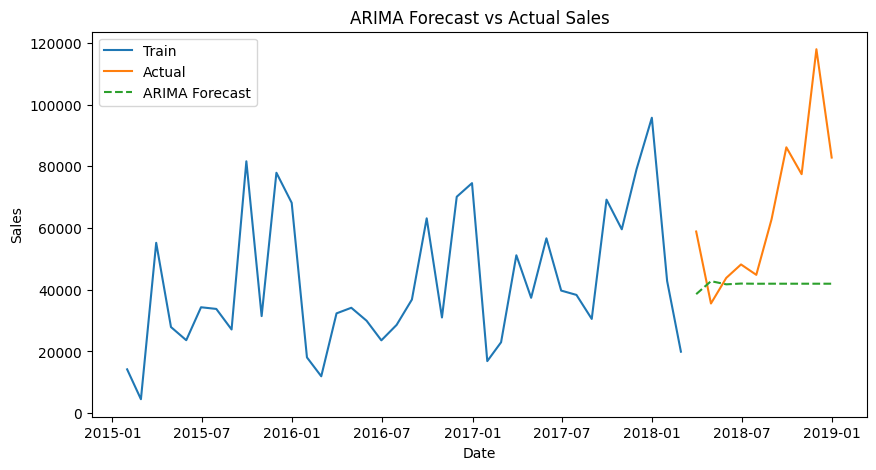

In [14]:
plt.figure(figsize=(10,5))
plt.plot(train["date"], train["sales"], label="Train")
plt.plot(test["date"], test["sales"], label="Actual")
plt.plot(test["date"], arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.legend()
plt.title("ARIMA Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()




ARIMA outperformed the naïve baseline but did not match the accuracy of the feature-based ML model, indicating that monthly sales dynamics exhibit nonlinear patterns beyond the assumptions of classical linear time-series models.



In [15]:
prophet_df = monthly.rename(columns={"date": "ds", "sales": "y"})

train_p = prophet_df.iloc[:split_idx]
test_p  = prophet_df.iloc[split_idx:]

m = Prophet()
m.fit(train_p)

future = m.make_future_dataframe(periods=len(test_p), freq="ME")
forecast = m.predict(future)

forecast_test = forecast.tail(len(test_p))
prophet_preds = forecast_test["yhat"].values


18:09:08 - cmdstanpy - INFO - Chain [1] start processing
18:09:08 - cmdstanpy - INFO - Chain [1] done processing


In [16]:


mse_prophet = mean_squared_error(test_p["y"], prophet_preds)
rmse_prophet = np.sqrt(mse_prophet)
mape_prophet = mape(test_p["y"], prophet_preds)

print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAPE: {mape_prophet:.2f}%")


Prophet RMSE: 14020.24
Prophet MAPE: 14.98%


In [17]:
results = pd.DataFrame({
    "Model": ["Baseline", "ARIMA", "Random Forest", "Prophet"],
    "RMSE": [51820, 34073, 24779, 14020],
    "MAPE (%)": [65.74, 32.30, 18.89, 14.98]
})

results


,Model,RMSE,MAPE (%)
0,Baseline,51820,65.74
1,ARIMA,34073,32.30
2,Random Forest,24779,18.89
3,Prophet,14020,14.98


---
### Final Conclusion

This analysis compared multiple forecasting approaches, including a naïve baseline, classical time-series modeling, feature-based machine learning, and trend–seasonality modeling. While ARIMA and Random Forest models provided meaningful improvements over the baseline, **Prophet achieved the best overall performance**, delivering the lowest RMSE and MAPE.

The results indicate that **monthly sales are strongly driven by trend and seasonal patterns**, which are captured more effectively by Prophet’s additive modeling framework. Based on its superior accuracy and interpretability, Prophet was selected as the most suitable model for monthly sales forecasting in this context.

---